In [1]:
# Importing Dependencies

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import numpy as np
import pandas as pd
import glob
import xarray as xr
import warnings
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
import rioxarray
from rasterio import features
from affine import Affine
import datetime

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from pyhdf.SD import SD, SDC

plt.style.use('ggplot')

warnings.filterwarnings('ignore')

In [13]:
# Loading AOD DATASET FILE PATH

aod_file = glob.glob('./Data/AOD/*')

aod_insat3D = glob.glob(aod_file[0]+'/*')
aod_insat3DR = glob.glob(aod_file[1]+'/*')
aod_modis_dir = glob.glob(aod_file[2]+'/*')

aod_file

['./Data/AOD\\INSAT3D', './Data/AOD\\INSAT3DR', './Data/AOD\\MODIS_2018']

In [14]:
# MODIS DIR contain sub folder with no time dimension

# Create empty list to store file path with time stamp
aod_modis_path = []
time_stamp = []

# Mention Starting Year
start_year = np.datetime64('2018')

for path in aod_modis_dir:
    
    aod_modis_path.append(glob.glob(path+'/*'))
    day_no  = int(path.split('\\')[-1]) # Day number according to file name i,e 001,002,003,...365
    time_stamp.append(start_year + np.timedelta64(day_no-1, 'D')) # add timestamp to that particular file index

aod_modis_path[:5],time_stamp[:5]

([['./Data/AOD\\MODIS_2018\\001\\MOD08_D3.A2018001.061.2018003215357.hdf'],
  ['./Data/AOD\\MODIS_2018\\002\\MOD08_D3.A2018002.061.2018003215942.hdf'],
  ['./Data/AOD\\MODIS_2018\\003\\MOD08_D3.A2018003.061.2018004083950.hdf'],
  ['./Data/AOD\\MODIS_2018\\004\\MOD08_D3.A2018004.061.2018005083354.hdf'],
  ['./Data/AOD\\MODIS_2018\\005\\MOD08_D3.A2018005.061.2018008181118.hdf']],
 [numpy.datetime64('2018-01-01'),
  numpy.datetime64('2018-01-02'),
  numpy.datetime64('2018-01-03'),
  numpy.datetime64('2018-01-04'),
  numpy.datetime64('2018-01-05')])

In [15]:
# Declare Datafield Name
DATAFIELD_NAME = 'AOD_550_Dark_Target_Deep_Blue_Combined_Mean'

# Temporary list to store data to make xarray dataset
DATA = []
TIME = []
LAT = []
LON = []

# Read MODIS file
for idx, FILE_NAME in  enumerate(aod_modis_path):
        
    hdf = SD(*FILE_NAME, SDC.READ)
    data_raw = hdf.select(DATAFIELD_NAME)
    data = data_raw[:,:].astype(np.double)
    
    # Read dataset.
    data_raw = hdf.select(DATAFIELD_NAME)
    data = data_raw[:,:].astype(np.double)

    # Read lat/lon.
    xdim = hdf.select('XDim')
    lon = xdim[:].astype(np.double)

    ydim = hdf.select('YDim')
    lat = ydim[:].astype(np.double)
    
    # Retrieve attributes.
    attrs = data_raw.attributes(full=1)
    lna=attrs["long_name"]
    long_name = lna[0]
    aoa=attrs["add_offset"]
    add_offset = aoa[0]
    fva=attrs["_FillValue"]
    _FillValue = fva[0]
    sfa=attrs["scale_factor"]
    scale_factor = sfa[0]        
    ua=attrs["units"]
    units = ua[0]

    # Fill 9999 with NaN value
    data[data == _FillValue] = np.nan
    data =  scale_factor * (data - add_offset) 
    datam = np.ma.masked_array(data, np.isnan(data))
    
    # Store result in DATA and TIME list
    TIME.append(time_stamp[idx])
    DATA.append(data)
    

# Make np array for list
TIME = np.array(TIME)
LAT = np.array(lat)
LON = np.array(lon)
DATA = np.array(DATA)

print("Data file is ready !!!")

Data file is ready !!!


In [16]:
# Read 3D and 3DR data 
ds_3DR = xr.open_mfdataset(aod_insat3DR)
ds_3D = xr.open_mfdataset(aod_insat3D)

# Create Modis Dataset
ds_modis = xr.Dataset(
        {
            'AOD': (['time','latitude', 'longitude'], DATA),
            'time': (['time'],TIME),
            'latitude': (['latitude'], LAT),
            'longitude': (['longitude'], LON),
        }
    )

# 1 Slicing
ds1_3DR = ds_3DR.sel(time=slice('2018','2019'),latitude=slice(39,8),longitude=slice(67,98)).load()
ds1_3D = ds_3D.sel(time=slice('2018','2019'),latitude=slice(39,8),longitude=slice(67,98)).load()
ds1_modis = ds_modis.sel(latitude=slice(39,8),longitude=slice(67,98))
ds1_merged = xr.concat([ds1_3DR, ds1_3D], dim='time').sortby('time')

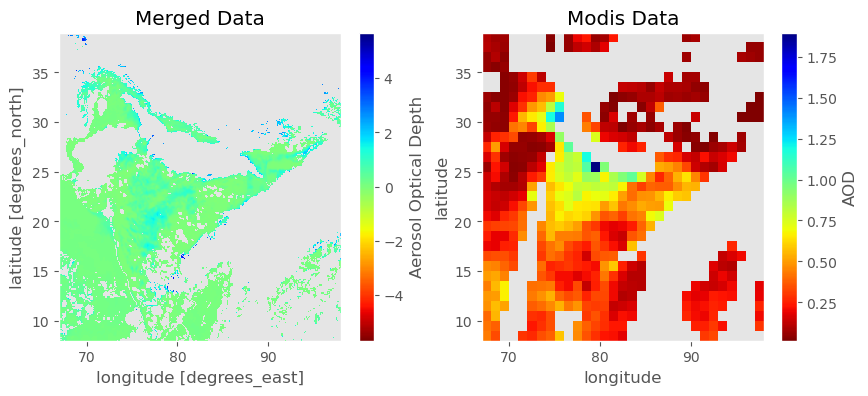

In [17]:
fig,ax = plt.subplots(1,2,figsize=(10,4))

ds1_merged.AOD.isel(time=0).plot(ax=ax[0],cmap='jet_r')
ax[0].set_title('Merged Data')

ds1_modis.AOD.isel(time=0).plot(ax=ax[1],cmap='jet_r')
ax[1].set_title('Modis Data')

plt.show()

In [18]:
ds1_merged

<xarray.Dataset>
Dimensions:    (time: 4475, latitude: 310, longitude: 310)
Coordinates:
  * latitude   (latitude) float64 38.95 38.85 38.75 38.65 ... 8.25 8.15 8.05
  * longitude  (longitude) float64 67.05 67.15 67.25 67.35 ... 97.75 97.85 97.95
  * time       (time) datetime64[ns] 2018-01-01T05:15:00 ... 2018-12-31T08:30:00
Data variables:
    AOD        (time, latitude, longitude) float32 nan nan nan ... 0.2794 nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [19]:
ds1_modis

<xarray.Dataset>
Dimensions:    (time: 365, latitude: 31, longitude: 31)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * latitude   (latitude) float64 38.5 37.5 36.5 35.5 34.5 ... 11.5 10.5 9.5 8.5
  * longitude  (longitude) float64 67.5 68.5 69.5 70.5 ... 94.5 95.5 96.5 97.5
Data variables:
    AOD        (time, latitude, longitude) float64 0.1 0.074 ... 0.126 0.113

In [20]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude="lat", longitude="lon",
              fill=np.nan, **kwargs):
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    shp_gpd = gpd.read_file(shp_path)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='longitude', latitude='latitude')
    return xr_da

In [23]:
# Regridding 3D and 3DR data
def regrid(res,ds):
    
    # Output resolution
    out_res = float(res)

    # Half of orginal resolution
    interval_window = out_res/2 
    new_lat = np.arange(8.5-interval_window, 38.5 + out_res, out_res) # Latitude label i.e 8,..,38
    new_lon = np.arange(67.5-interval_window, 97.5 + out_res, out_res) # longitude Label i.e 68,..,98


    ds = ds.groupby_bins("longitude", bins=new_lon).mean(dim="longitude").groupby_bins("latitude", bins=new_lat).mean(dim="latitude")

   
    # Renaming longitude and latitude coordinate
    ds = ds.rename({"longitude_bins":"longitude","latitude_bins":"latitude"})

    ds['latitude'] = new_lat[:-1] + interval_window
    ds['longitude'] = new_lon[:-1] + interval_window
    
    #ds1 = ds[['time','latitude','longitude','AOD']]
    
    return ds



In [24]:
# 2 - Regridding
ds2_merged = regrid(1,ds1_merged)

In [25]:
# 3 - Shape file dir
sf_dir = './Data/India_Boundary/India_Boundary.shp'

ds_merged_mask = add_shape_coord_from_data_array(ds2_merged, sf_dir, "MASK")
ds_merged_mask = ds_merged_mask.where(ds_merged_mask.MASK==0, other=np.nan)
ds3_merged_regrid = ds_merged_mask.drop_vars('MASK')

ds_merged_mask = add_shape_coord_from_data_array(ds1_merged, sf_dir, "MASK")
ds_merged_mask = ds_merged_mask.where(ds_merged_mask.MASK==0, other=np.nan)
ds3_merged = ds_merged_mask.drop_vars('MASK')

ds_modis_mask = add_shape_coord_from_data_array(ds1_modis, sf_dir, "MASK")
ds_modis_mask = ds_modis_mask.where(ds_modis_mask.MASK==0, other=np.nan)
ds3_modis = ds_modis_mask.drop_vars('MASK')

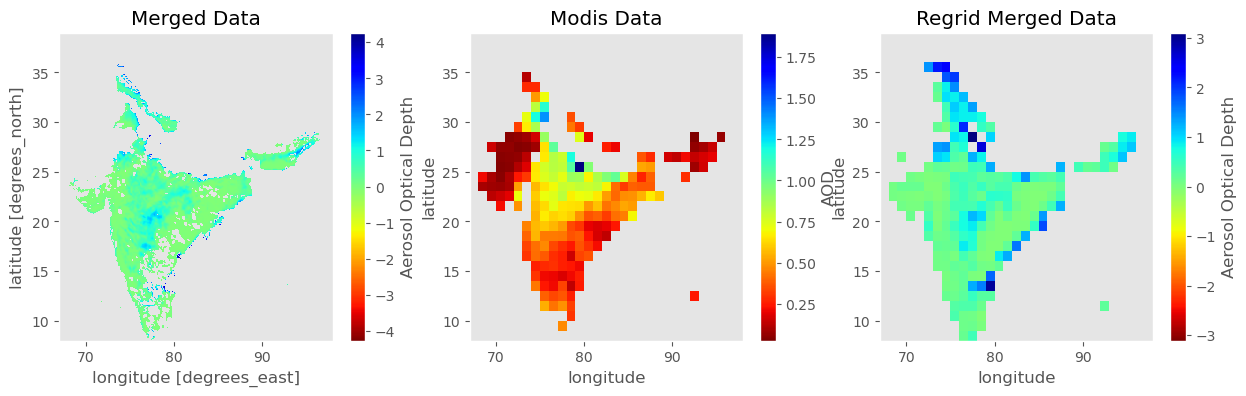

In [26]:
fig,ax = plt.subplots(1,3,figsize=(15,4))

ds3_merged.AOD.isel(time=0).plot(ax=ax[0],cmap='jet_r')
ax[0].set_title('Merged Data')

ds3_modis.AOD.isel(time=0).plot(ax=ax[1],cmap='jet_r')
ax[1].set_title('Modis Data')

ds3_merged_regrid.AOD.isel(time=0).plot(ax=ax[2],cmap='jet_r')
ax[2].set_title('Regrid Merged Data')

plt.show()

In [27]:
ds3_merged

<xarray.Dataset>
Dimensions:    (time: 4475, latitude: 310, longitude: 310)
Coordinates:
  * latitude   (latitude) float64 38.95 38.85 38.75 38.65 ... 8.25 8.15 8.05
  * longitude  (longitude) float64 67.05 67.15 67.25 67.35 ... 97.75 97.85 97.95
  * time       (time) datetime64[ns] 2018-01-01T05:15:00 ... 2018-12-31T08:30:00
Data variables:
    AOD        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [28]:
# 4 - FILTERING DATASET
def twoSig_pos_rule(group):
    
    count = group.count(dim='time')
    mean  = group.mean(dim='time')
    std = group.std(dim = 'time')
    
    res = mean + 1*std
    return res.where(count>=8)

def twoSig_neg_rule(group):
    
    count = group.count(dim='time')
    mean  = group.mean(dim='time')
    std = group.std(dim = 'time')
    
    res = mean - 1*std
    return res.where(count>=8)

def twoSigfilter(ds):
   
    # Converting hourly to daily timestamp
    daily_timestamp = ds.time.dt.floor('1D')
    unique_day = np.unique(daily_timestamp)
    
    # COUNT PLOT ON TIME DIMENSION
    ds_day_count = ds.groupby(daily_timestamp).count(dim='time').rename({'floor':'time'})

    # Calculating mean + 2*sigma
    ds_twoSig_pos= ds.groupby(daily_timestamp).apply(twoSig_pos_rule).rename({'floor': 'time'})

    # Calculating mean - 2*sigma
    ds_twoSig_neg= ds.groupby(daily_timestamp).apply(twoSig_neg_rule).rename({'floor': 'time'})

    # re-arrange coordinates
    ds_twoSig_pos = ds_twoSig_pos[['time','latitude','longitude','AOD']]
    ds_twoSig_neg = ds_twoSig_neg[['time','latitude','longitude','AOD']]

    # Assigning Time Coordinate value as data_set timestamp since it is 0,1,..365 format
    
    print(len(ds_day_count.time.values))
    ds_twoSig_pos.coords['time'] = unique_day
    ds_twoSig_neg.coords['time'] = unique_day
    
    # Flooring hourly time to day time and generate duplicate time index for same hour
    ds.coords['time'] = ds.time.dt.floor('1D')

    # Create a mask for filtering out the data
    mask = (ds['AOD'] < ds_twoSig_pos.sel(time=ds['time'])) & (ds['AOD'] > ds_twoSig_neg.sel(time=ds['time']))

    # Apply the mask to filter out the data
    filtered_data = ds.where(mask)
    
    return filtered_data

ds4_filter = twoSigfilter(ds3_merged)
ds4_regrid_filter = twoSigfilter(ds3_merged_regrid)

365
365


In [29]:
def plot_aod_time_series(ds_merged,ds_merged_filtered,ds_modis):
    
    # Function to resample the data according to time parameter
    t = ['1D','1M']
    titles = ['Daily','Montly']
    n,m = 2,2
    fig, ax = plt.subplots(nrows=n,ncols=m,figsize=(20,15) )
    
    for r in range(n):
        
        if t[r]:
            ds_merged = ds_merged.resample(time=t[r]).mean()
            ds_merged_filtered = ds_merged_filtered.resample(time=t[r]).mean()
            ds_modis = ds_modis.resample(time=t[r]).mean()
            
        c = 0
        
        ########## Mean Plot
        
        data1_mean = ds_merged['AOD'].mean(dim=('latitude', 'longitude'))
        data2_mean = ds_merged_filtered['AOD'].mean(dim=('latitude', 'longitude'))
        data3_mean = ds_modis['AOD'].mean(dim=('latitude', 'longitude'))

        
        data1_mean.plot.line(ax=ax[r][c], label='Merged Data')
        data2_mean.plot.line(ax=ax[r][c], label='Merged 1-sigma Data')
        data3_mean.plot.line(ax=ax[r][c], label='Modis Data')

        ax[r][c].legend()
        ax[r][c].set_xlabel('(Time)',weight='bold')
        ax[r][c].set_ylabel('(Mean AOD)',weight='bold')
        ax[r][c].set_title(f'Mean AOD {titles[r]}',weight='bold')

        ########## Count Plot
        
        data1_count = ds_merged['AOD'].count(dim=('latitude', 'longitude'))
        data2_count = ds_merged_filtered['AOD'].count(dim=('latitude', 'longitude'))
        data3_count = ds_modis['AOD'].count(dim=('latitude', 'longitude'))

        data1_count.plot.line(ax=ax[r][c+1], label='Merged Data')
        data2_count.plot.line(ax=ax[r][c+1], label='Merged 1-sigma Data')
        data3_count.plot.line(ax=ax[r][c+1], label='Modis Data')


        
        ax[r][c+1].legend()
        ax[r][c+1].set_xlabel('(Time)', weight='bold')
        ax[r][c+1].set_ylabel('(AOD Observation)',weight='bold')
        ax[r][c+1].set_title(f'Observed AOD {titles[r]}',weight='bold')
        fig.subplots_adjust(hspace=0.4)
        #plt.savefig('./plots/aod_plot/filter_2_sigma.png')

plt.show()

### INSAT : 0.1 x 0.1 and Modis : 1 x 1 Before Regridding

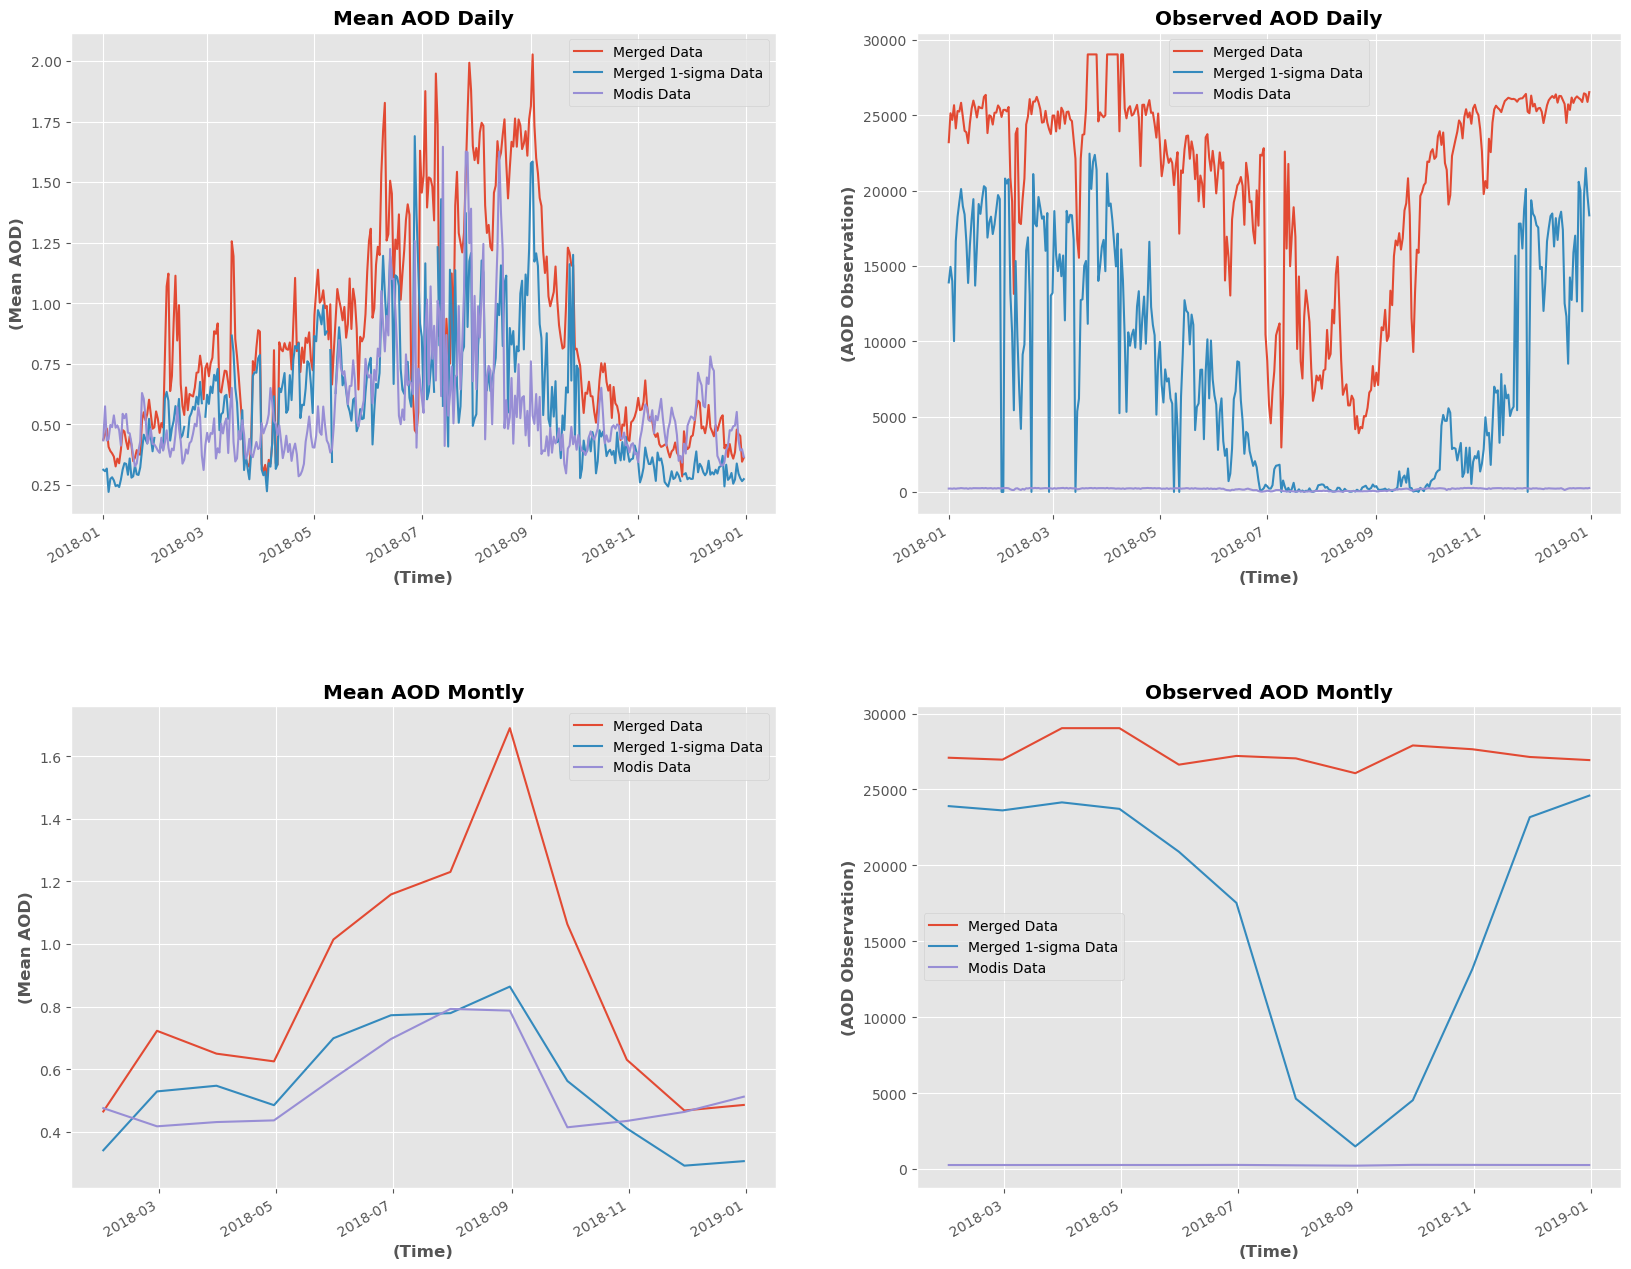

In [30]:
plot_aod_time_series(ds3_merged,ds4_filter,ds3_modis)


### Regridded to 1 x 1

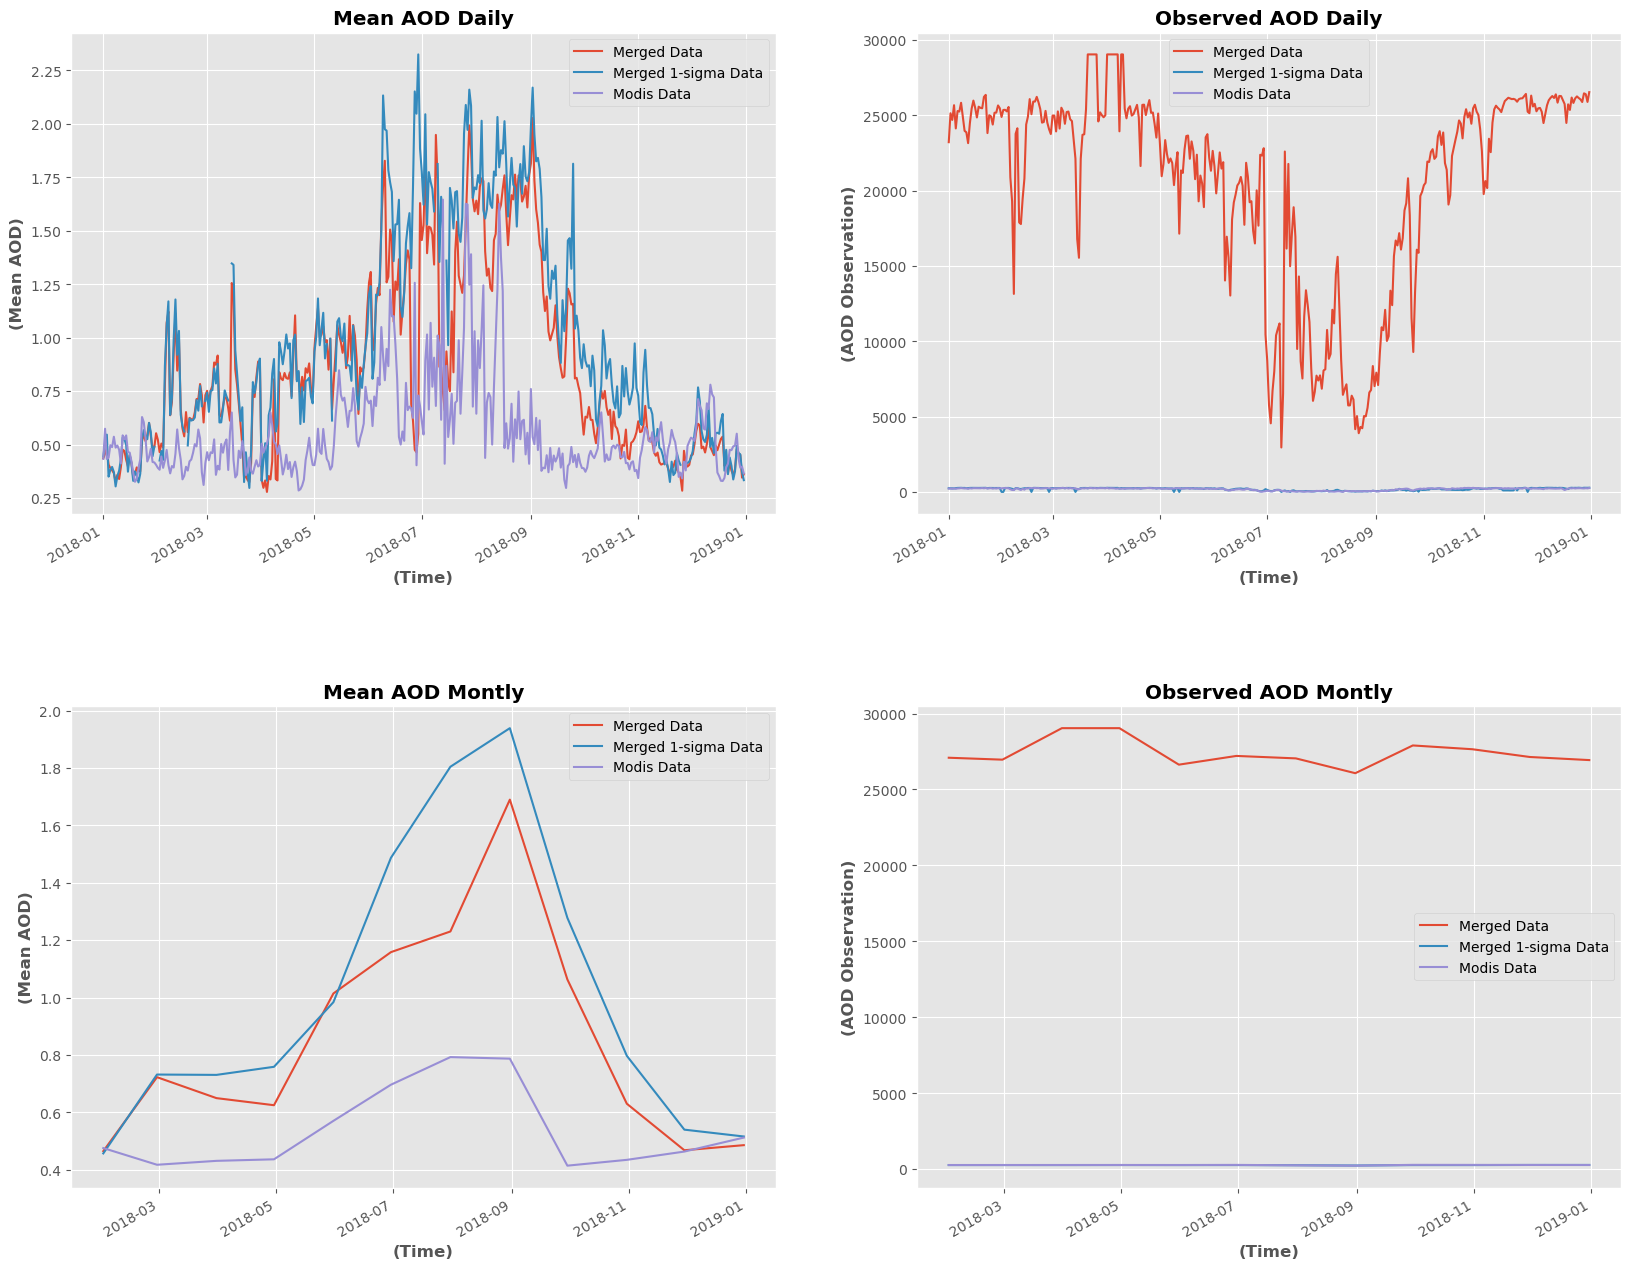

In [32]:
plot_aod_time_series(ds3_merged,ds4_regrid_filter,ds3_modis)

In [33]:
ds4_regrid_filter

<xarray.Dataset>
Dimensions:    (latitude: 31, longitude: 31, time: 4475)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-01 ... 2018-12-31
  * longitude  (longitude) float64 67.5 68.5 69.5 70.5 ... 94.5 95.5 96.5 97.5
  * latitude   (latitude) float64 8.5 9.5 10.5 11.5 12.5 ... 35.5 36.5 37.5 38.5
Data variables:
    AOD        (latitude, longitude, time) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [34]:
def rmse_graph(ds1,ds2):
    ds1 = ds1.resample(time='1D').mean()
    ds2 = ds2.resample(time='1D').mean()
    
    # calculate differences and metrics
    diff = ds1 - ds2
    mean_bias = diff.mean(dim=('latitude', 'longitude'))

    rmse = np.sqrt(((ds1 - ds2)**2).mean(dim=('latitude', 'longitude')))

    count_1 = ds1.count(dim=('latitude', 'longitude'))
    count_2 = ds2.count(dim=('latitude', 'longitude'))

    corr_coeff = xr.corr(ds1.AOD, ds2.AOD, dim=('latitude', 'longitude'))

    # create the plot
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(20, 14), sharex=True)

    # add each metric as a separate subplot
    # add each metric as a separate subplot
    rmse.AOD.plot.line(ax=axs[0], marker='o', label='RMSE', color='blue', linewidth=2)
    mean_bias.AOD.plot.line(ax=axs[1], marker='o', label='Mean Bias', color='red', linewidth=2)
    count_1.AOD.plot.line(ax=axs[2], marker='o', label='Mereged', color='green', linewidth=2)
    count_2.AOD.plot.line(ax=axs[2], marker='^', label='Modis', color='purple', linewidth=2)
    corr_coeff.plot.line(ax=axs[3], marker='o', label='Correlation Coefficient', color='orange', linewidth=2)

    # add legend
    axs[2].legend()

    # set axis labels and custom x-ticks
    axs[0].set_ylabel('RMSE', fontweight='bold')
    axs[1].set_ylabel('Mean Bias', fontweight='bold')
    axs[2].set_ylabel('Count', fontweight='bold')
    axs[3].set_ylabel('Correlation Coefficient', fontweight='bold')
    axs[3].set_xlabel('Time', fontweight='bold')

    axs[0].set_xticks(ds1['time'][::30],fontweight='bold')  # set x-ticks to every 30th date
    axs[1].set_xticks(ds1['time'][::30],fontweight='bold')  # set x-ticks to every 30th date
    axs[2].set_xticks(ds1['time'][::30],fontweight='bold')  # set x-ticks to every 30th date

    # add grid
    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)

    # adjust layout and show plot
    plt.tight_layout()
    plt.show()


## regrid insat vs modis

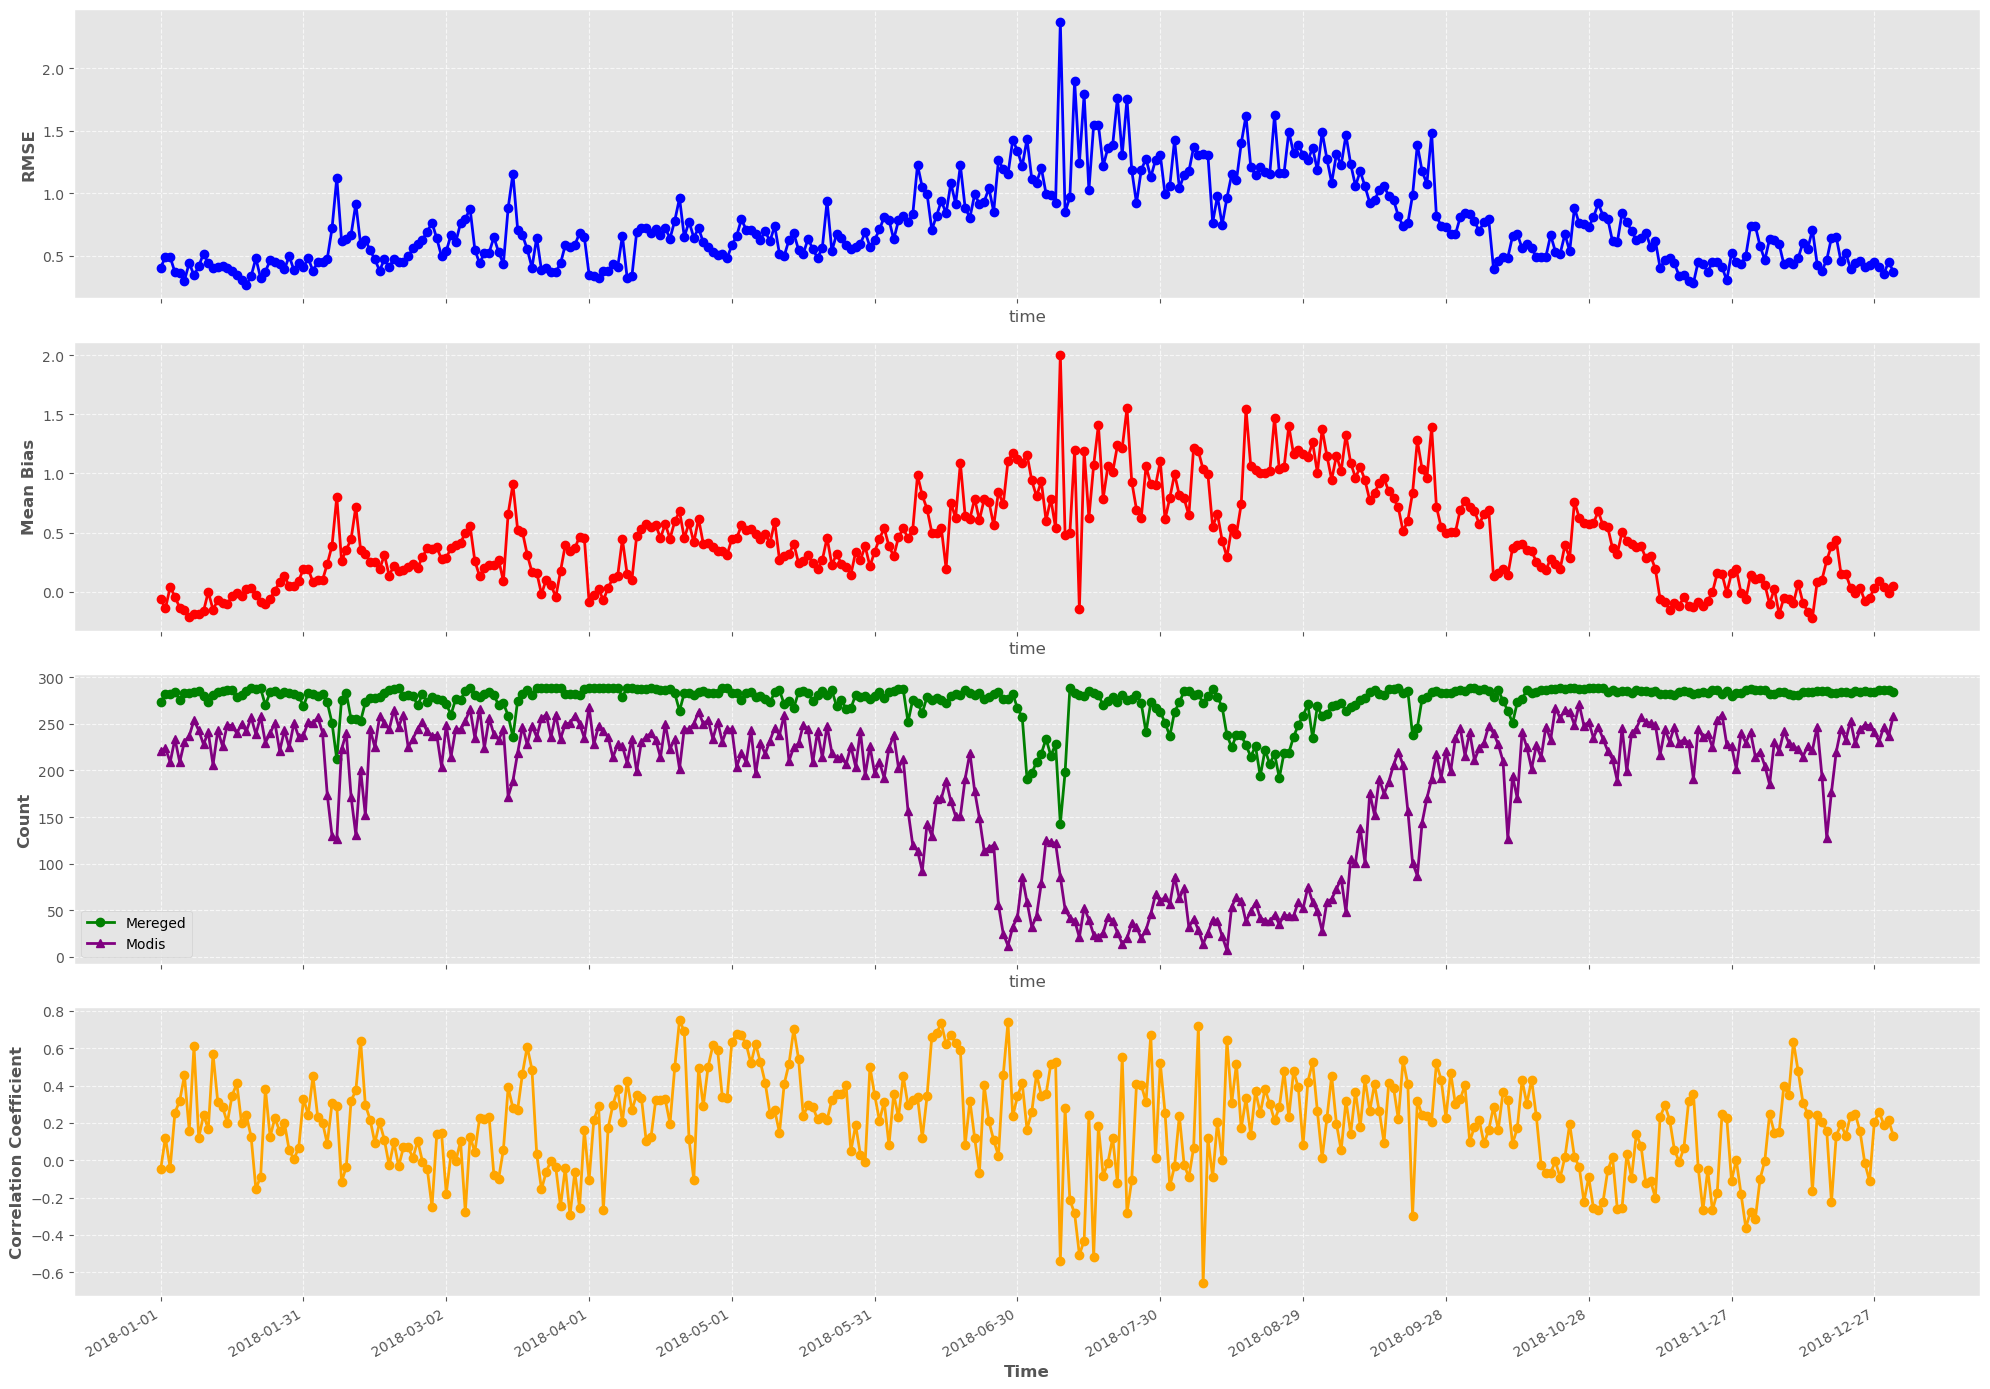

In [35]:
rmse_graph(ds3_merged_regrid,ds3_modis)

## regrid + filter insat vs modis

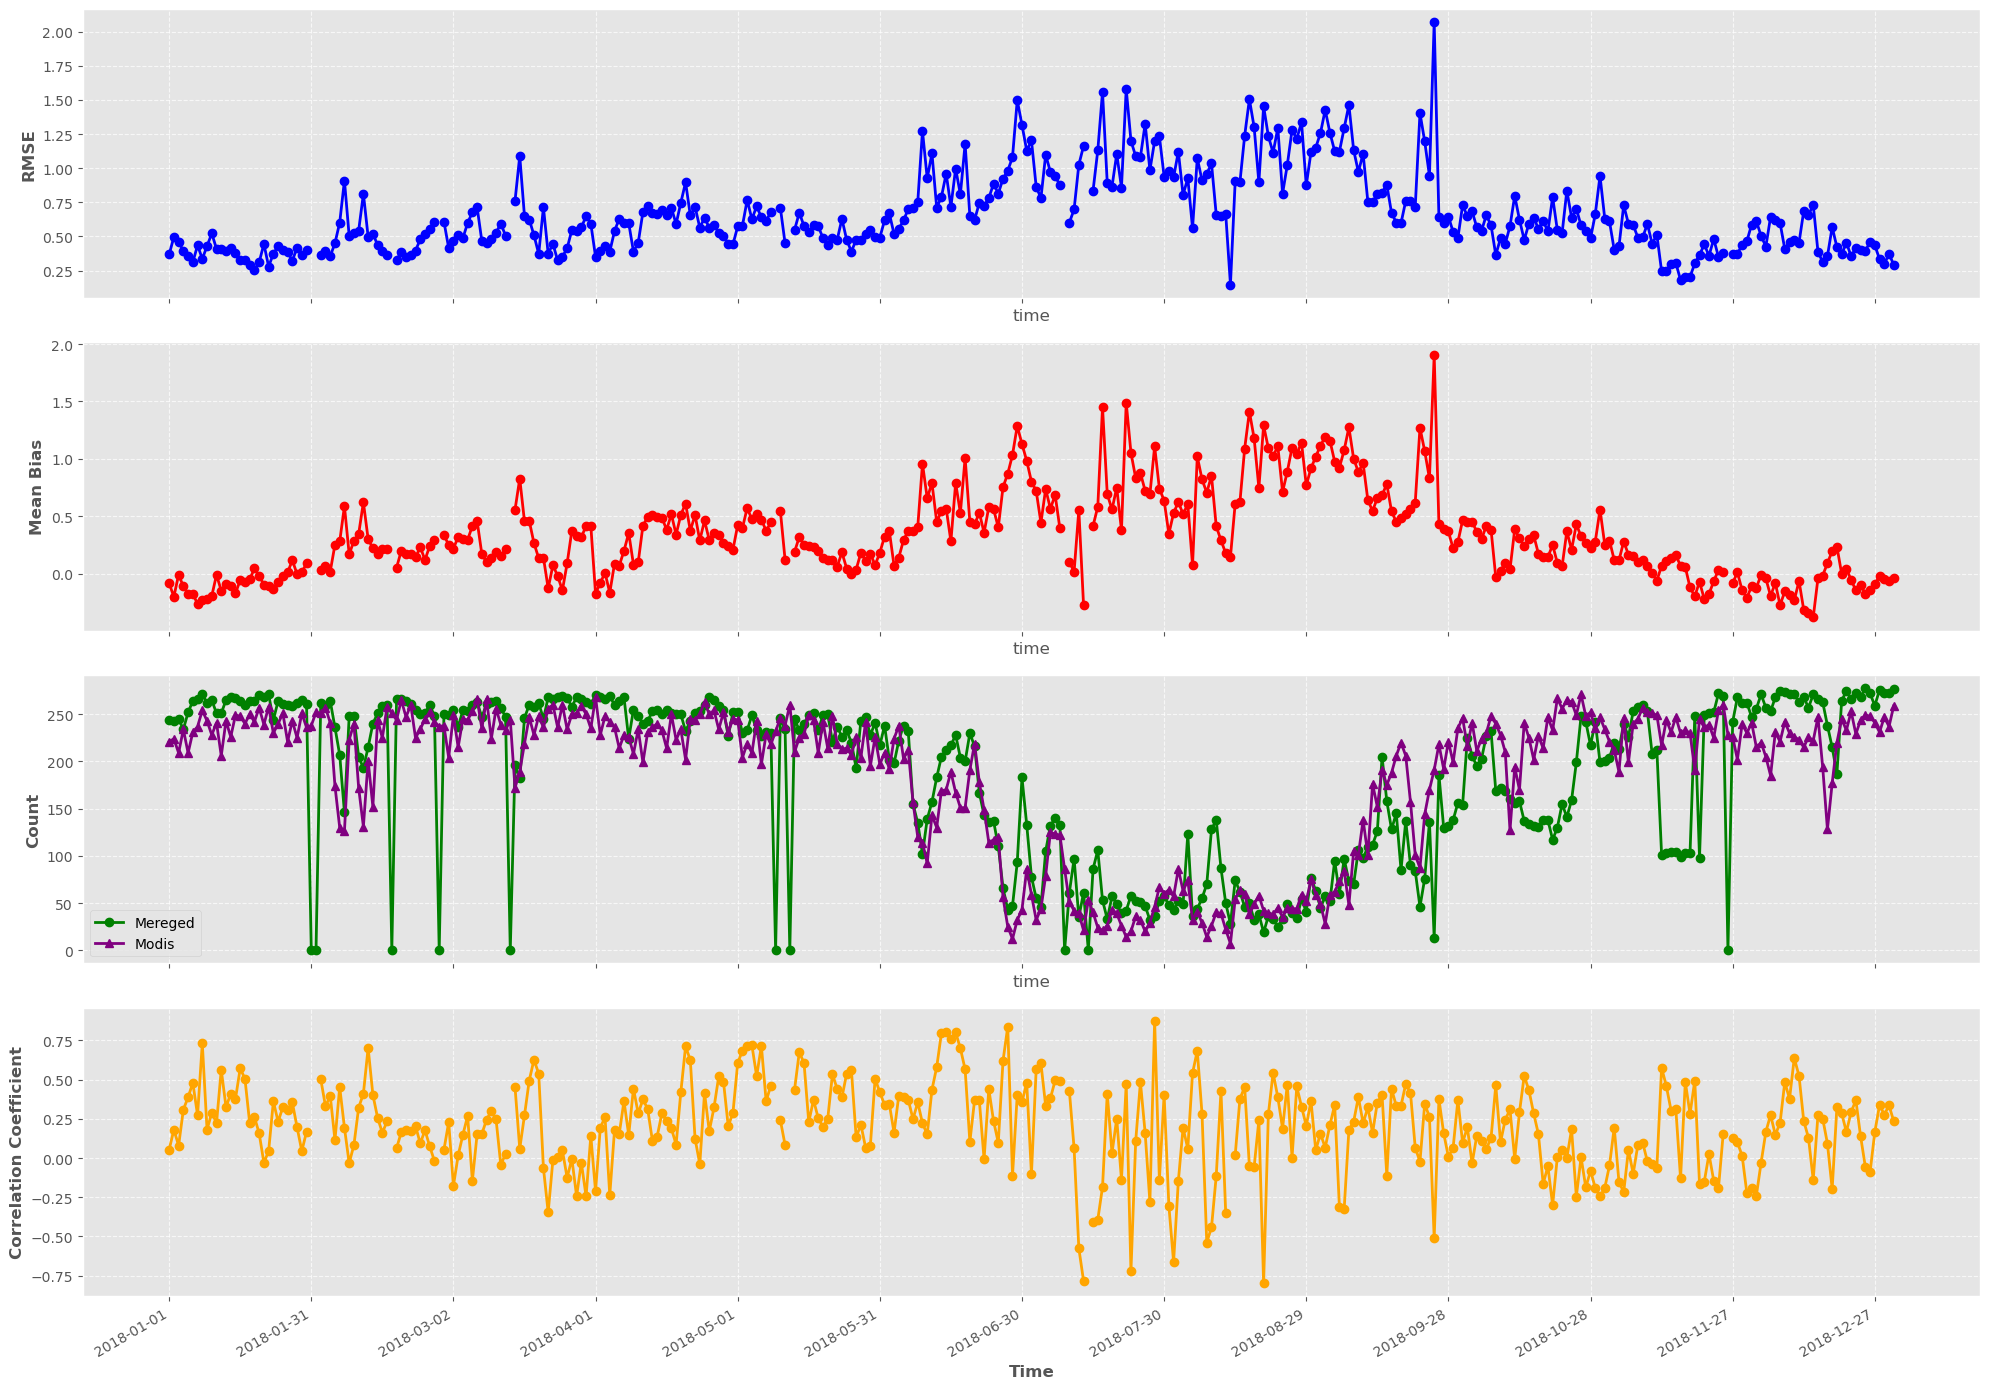

In [36]:
rmse_graph(ds4_regrid_filter,ds3_modis)

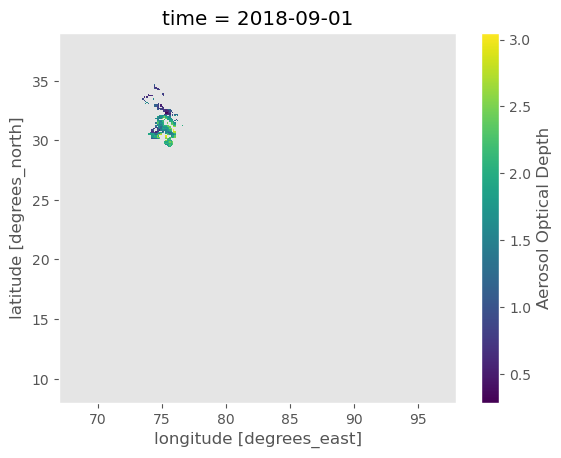

In [37]:
t= ds4_filter.resample(time='1D').mean()

t.AOD.sel(time='2018-09-01').plot()

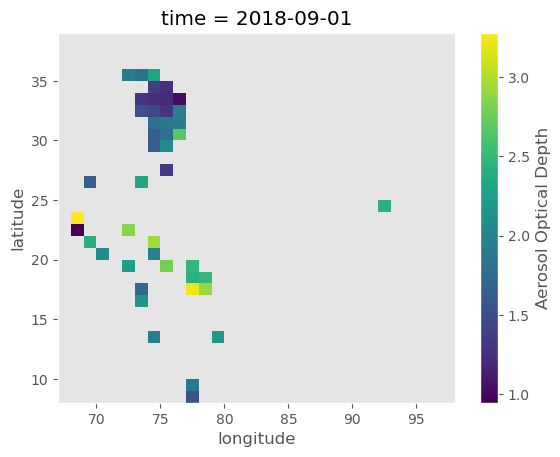

In [38]:
t= ds4_regrid_filter.resample(time='1D').mean()

t.AOD.sel(time='2018-09-01').plot()